In [1]:
import joblib
from sklearn.model_selection import train_test_split

In [3]:
preprocessor = joblib.load('preprocessor.pkl')

In [5]:
import pandas as pd

In [7]:
df = pd.read_csv('clean_churn_data.csv')

In [12]:
X=df.drop('Churn',axis=1)

In [18]:
y=df.Churn


In [20]:
y

0       0
1       0
2       1
3       0
4       1
       ..
7027    0
7028    0
7029    0
7030    1
7031    0
Name: Churn, Length: 7032, dtype: int64

In [22]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

In [24]:
# Transform data
X_train_transformed = preprocessor.transform(X_train)
X_test_transformed = preprocessor.transform(X_test)


In [26]:
X_train_transformed

<5625x5670 sparse matrix of type '<class 'numpy.float64'>'
	with 112500 stored elements in Compressed Sparse Row format>

In [28]:
X_test_transformed

<1407x5670 sparse matrix of type '<class 'numpy.float64'>'
	with 26733 stored elements in Compressed Sparse Row format>

### Train Logistic Regression

In [31]:
from sklearn.linear_model import LogisticRegression

In [33]:
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train_transformed,y_train)

LogisticRegression(max_iter=1000)

###  Train Random Forest



In [36]:
from sklearn.ensemble import RandomForestClassifier

In [38]:
rf = RandomForestClassifier(n_estimators=100,random_state=42)
rf.fit(X_train_transformed,y_train)

RandomForestClassifier(random_state=42)

In [44]:
!pip install xgboost


Defaulting to user installation because normal site-packages is not writeable
   ---------------------------------------- 0.0/150.0 MB ? eta -:--:--
   ---------------------------------------- 0.0/150.0 MB ? eta -:--:--
   ---------------------------------------- 0.3/150.0 MB ? eta -:--:--
   ---------------------------------------- 0.5/150.0 MB 1.4 MB/s eta 0:01:48
   ---------------------------------------- 0.8/150.0 MB 1.3 MB/s eta 0:01:52
   ---------------------------------------- 1.0/150.0 MB 1.3 MB/s eta 0:01:56
   ---------------------------------------- 1.3/150.0 MB 1.2 MB/s eta 0:02:02
   ---------------------------------------- 1.6/150.0 MB 1.3 MB/s eta 0:01:56
    --------------------------------------- 2.1/150.0 MB 1.3 MB/s eta 0:01:53
    --------------------------------------- 2.4/150.0 MB 1.3 MB/s eta 0:01:52
    --------------------------------------- 2.6/150.0 MB 1.3 MB/s eta 0:01:52
    --------------------------------------- 2.9/150.0 MB 1.4 MB/s eta 0:01:48
    ---


[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [50]:
from xgboost import XGBClassifier

In [52]:
xgb = XGBClassifier(use_label_encoder=False,eval_matric='logloss')
xgb.fit(X_train_transformed,y_train)

C:\Users\ABHAY\AppData\Roaming\Python\Python311\site-packages\xgboost\training.py:183: UserWarning: [08:34:05] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "eval_matric", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_matric='logloss', eval_metric=None,
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None, ...)

In [54]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]
    return {
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'F1': f1_score(y_test, y_pred),
        'ROC AUC': roc_auc_score(y_test, y_proba)
    }

results = {
    'Logistic Regression': evaluate_model(log_reg, X_test_transformed, y_test),
    'Random Forest': evaluate_model(rf, X_test_transformed, y_test),
    'XGBoost': evaluate_model(xgb, X_test_transformed, y_test)
}

import pandas as pd
pd.DataFrame(results).T.sort_values(by='F1', ascending=False)


,Accuracy,Precision,Recall,F1,ROC AUC
Logistic Regression,0.803838,0.648485,0.572193,0.607955,0.835719
XGBoost,0.766880,0.565714,0.529412,0.546961,0.808840
Random Forest,0.783937,0.625899,0.465241,0.533742,0.817187


Model: LogReg
Model: RandomForest
Model: XGBoost


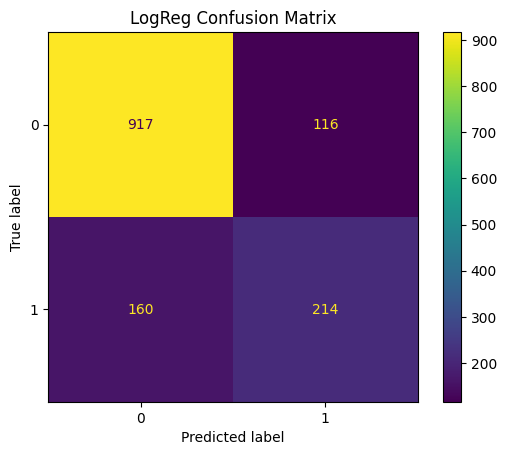

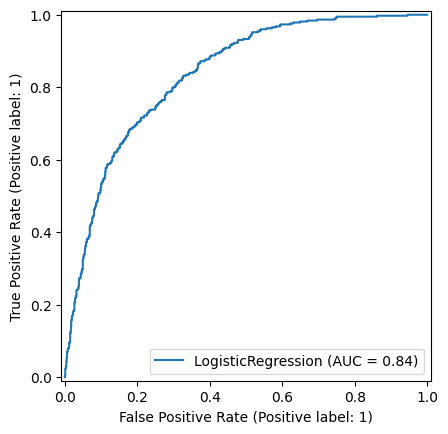

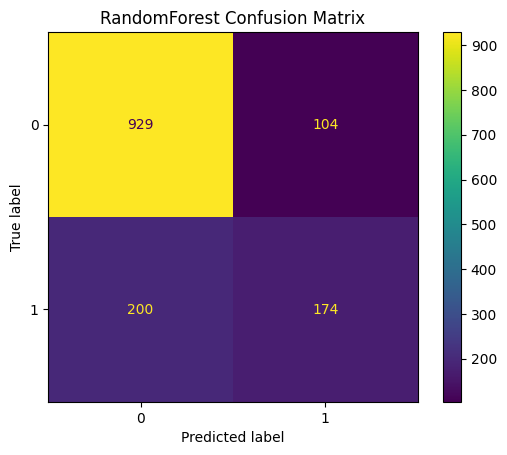

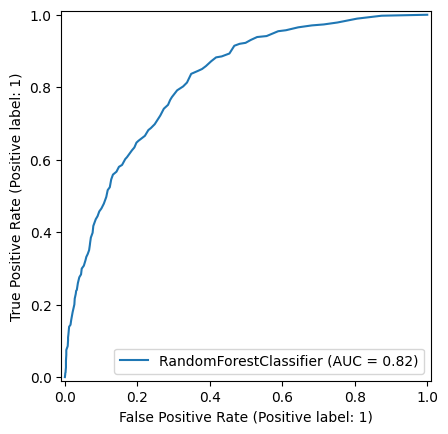

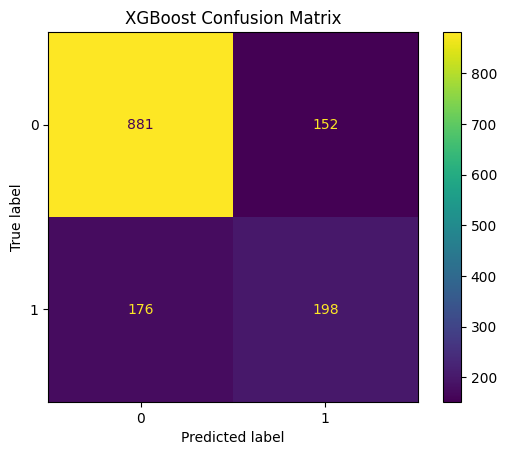

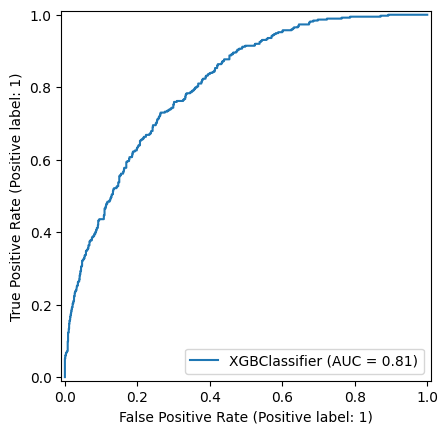

In [56]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay

for model, name in zip([log_reg, rf, xgb], ["LogReg", "RandomForest", "XGBoost"]):
    print(f"Model: {name}")
    
    # Confusion Matrix
    disp = ConfusionMatrixDisplay.from_estimator(model, X_test_transformed, y_test)
    disp.ax_.set_title(f'{name} Confusion Matrix')
    
    # ROC Curve
    RocCurveDisplay.from_estimator(model, X_test_transformed, y_test)


In [58]:
joblib.dump(log_reg,'best_model.pkl')

['best_model.pkl']

### Model Comparison Summary

| Model               | Accuracy  | Precision | Recall   | F1 Score | ROC AUC  |
|-------------------- |---------- |-----------|--------- |----------|----------|
| Logistic Regression | 0.803838  |	0.648485  |	0.572193 | 0.607955	| 0.835719 |
| Random Forest       | 0.783937  |	0.625899  |	0.465241 | 0.533742	| 0.817187  |
| XGBoost             | 0.76688  |0	0.56571  |4	0.52941 | 	0.546961| 	0.80884  |

- **log_reg performed best** with the highest ROC AUC and F1.
- Models handle class imbalance reasonably well.
- Saved best model for deployment.
